In [1]:
%%javascript
    $("#homeButton").remove()
    $('body').append('<a href="#'+$("h1,h2,h3:eq(0)").attr("id")+'" style="position: fixed; bottom: 10px; right: 10px;" type="button" class="btn btn-success btn-circle btn-lg"><i class="glyphicon glyphicon-link" id="homeButton"></i></a>');
    $("#MainMenu").remove()
    var menu = 
      '<div id="MainMenu" style="position: fixed; top: 120px; right: 10px; z-index:6; max-height: 500px;">'+
        '<div class="list-group panel" >'+
          '<a href="#collapseMenu" class="list-group-item list-group-item-success" data-toggle="collapse" data-parent="#MainMenu">Indíce<i class="fa fa-caret-down"></i></a>'+
          '<div class="collapse" id="collapseMenu" style="overflow-y: overlay; max-height: 500px;">'+
          '</div>'+
        '</div>'+
      '</div>'
   
    var parent = $(menu)
    var arrayIds = []
    $("h1,h2,h3").attr("id",function(id,Value){
        if(Value != ""){
            var content = (Value.replace(new RegExp('-', 'g'), ' '));
            content = "&nbsp;".repeat(parseInt($(this).prop("tagName")[1])*2-1) + content;
            $(parent).find("#collapseMenu").append('<a href="#'+Value+'" style="position:relative;" class="list-group-item" data-parent="#SubMenu1">'+content+'</a>');
        }
    })
$('body').append(parent)

<img src="static/Datio.png" style="width: 20%; margin-left: 70%;">
<br>

# Analisis de Principales Componentes (PCA)

<img src='static/spark.png' width="30%" height="30%" />

---

* Principal component analysis
 - Spectral decomposition of covariance matrix.
 - Constant probability density contours and confidence hyper-ellipses.
 - Maximum likelihood estimators.
* Simulating multivariate normal random vectors.


# Principal component analysis

# Analisis de Principales Componentes

## Bases matematicas 

    En esta sección vamos a dar algunos de los elementos matematicos necesarios para desarrollar y entender PCA

### Estadística

Vamos a representar a la muestra de una población como $ X $ un ejemplo sería: <br/>
$$ X = [1,2,4,6,.....,98]$$ 
donde $X_4=6$ $\leftarrow$ un valor dentro de nuestra muestra

### Media

La media de una dimension se define como:
$$\overline{X} = \frac{
                            \sum_{i=1}^{n}X_i
                       }{n}$$
                       
### Desviacion estandar

" La distancia promedio de la media a los puntos de los datos "

$$ s = \sqrt{ \frac{
                 \sum_{i=1}^{n}(X_i - \overline{X} )^2
            }{n-1} } $$

### Varianza


$$ s^2 = \frac{
                 \sum_{i=1}^{n}(X_i - \overline{X} )^2
            }{n-1} $$
            
### Covarianza

Esta formula nos sirve para saber que tanto una dimension varia con respecto a otra:

$$ cov(X,Y) = \frac{
                 \sum_{i=1}^{n}(X_i - \overline{X} )(Y_i - \overline{Y} )
            }{n-1} $$
### Matriz de covarianza

$$ C^{nxn} = (C_{i,j},C_{j,i} = cov(Dim_i,Dim_j)) $$

Donde C^{nxn} es una matriz con n columnas y n renglones

## Algebra lineal
Para PCA necesitamos saber acerca de $eigenvalores$ y $eigenvectores$

### Eigenvectors y Eigenvalues

Sea $A$ una matriz cuadrada con eigenvalores ($\lambda$) y eigenvectores ($v$), siguiendo la siguiente regla:

$$ A\overrightarrow{v} = \lambda \overrightarrow{v}$$

## Otros temas importantes

- multiplicidad algebraica y geometrica
- Singular Value Decomposition (SVD)
- Lagrange multiplier

## Desarrollo del metodo

Nustro objetivo sera buscar una transformacion que mejor conserve la informacion y reducir la dimensionalidad (complejidad) de nuestros datos
<img src='static/pca1.gif'>

El nuevo punto mapeado
$$ U_1^T X $$

Donde $U_1$ es el vector que usamos para transformar los datos. <br/>
Un enfoque de conservar la mayor informacion posible es maximizando la varianza, por lo tanto tenemos que maximizar:

$$ var(U_1^T X) $$

Desagregando la formula:


$$ var(U_1^T X) = U_1^TSU_1 $$

Donde $S$ es la matriz de covarianza de $X$

Bajo esta condicion cualquier $U_1$ podria maximizar la expresion por lo tanto necesitamos poner una restriccion:

$$ U_1^TU_1 = 1$$

Usando Lagrange Multiplier obtenemos la siguiente expresion:
$$  U_1^TSU_1 = \lambda$$

La expresion es la expresion de los vectores y valores caracteristicos de $S$.

Al obtener los valores caracteristicos de $S$ los ordenamos de mayor a menor, y elegimos el vector correspondiente al valor caracteristico mayor como nuestro primer componente, y asi con el resto de los siguientes componentes

$$ \lambda_1 > \lambda_2 > \lambda_3 > ...  > \lambda_d $$
$$     u_1   >   u_2     >     u_3   > ... > u_d $$

## Example  [Principal component analysis of winne data set]

### Cargando las librerias

In [2]:
run MvaUtils.py

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
from IPython.display import display, HTML
from pyspark.sql import SQLContext
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.sql import Column as c
from pyspark.sql.functions import array, udf, lit, col as c
import pyspark.sql.functions as f
pd.set_option('max_colwidth',100)
plt.style.use('seaborn-paper')

Cargando el spark Context

In [4]:

try:
    sc = SparkContext('local[*]')
except:
    sc = SparkContext.getOrCreate('local[*]')

sqlContext = SQLContext(sc)

Leyendo los dataframes

In [5]:
whiteWinnePath = 'data/winequalityWhite.csv'
redWinnePath = 'data/winequalityRed.csv'

whiteWinneDF = sqlContext.createDataFrame(pd.read_csv(whiteWinnePath)).withColumn('type',lit(0))

redWinneDF = sqlContext.createDataFrame(pd.read_csv(redWinnePath)).withColumn('type',lit(1))
        
redWinneDF.printSchema()

root
 |-- fixedAcidity: double (nullable = true)
 |-- volatileAcidity: double (nullable = true)
 |-- citricAcid: double (nullable = true)
 |-- residualSugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- freeSulfurDioxide: double (nullable = true)
 |-- totalSulfurdioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: long (nullable = true)
 |-- type: integer (nullable = false)



Dividiendo conjuntos de entrenamiento y prueba

In [6]:
whiteTrainingDF, whiteTestingDF = whiteWinneDF.randomSplit([0.7,0.3])

redTrainingDF, redTestingDF = redWinneDF.randomSplit([0.7,0.3])
        
trainingDF = whiteTrainingDF.union(redTrainingDF)

testingDF = whiteTestingDF.union(redTestingDF)

Preparando el dataframe para PCA

In [7]:
idCol = ['type']

features = [column for column in redWinneDF.columns if column not in idCol]

p = len(features)

meanVector = trainingDF.describe().where(c('summary')==lit('mean'))\
                       .toPandas().as_matrix()[0][1:p+1]
        
labeledVectorsDF = trainingDF.select(features+['type']).rdd\
                             .map(lambda x:(Vectors.dense(x[0:p]-Vectors.dense(meanVector)),x[p]))\
                             .toDF(['features','type'])

labeledVectorsDF.limit(5).toPandas()

,features,type
0,"[-2.20879048249, -0.166617096277, 0.240927517074, -3.97387089667, -0.0298993170302, -6.850297422...",0
1,"[-2.20879048249, 0.213382903723, -0.179072482926, 2.82612910333, -0.0238993170302, 4.14970257766...",0
2,"[-2.10879048249, -0.00661709627671, -0.0990724829258, -3.87387089667, -0.0288993170302, -12.8502...",0
3,"[-2.10879048249, -0.00661709627671, -0.0990724829258, -3.87387089667, -0.0288993170302, -12.8502...",0
4,"[-2.10879048249, -0.00661709627671, -0.0990724829258, -3.87387089667, -0.0288993170302, -12.8502...",0


### Generando PCA

,explained variance
0,0.953103
1,0.040951


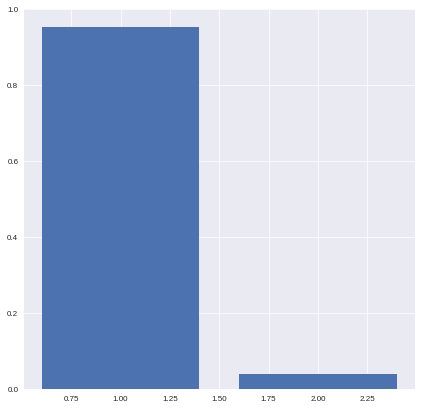

In [8]:
k=2
pcaModel = PCA(k=k, inputCol="features", outputCol="featuresPCA").fit(labeledVectorsDF)
transformedFeaturesDF = pcaModel.transform(labeledVectorsDF)

plt.figure(figsize=(7,7))
eigenvalues = [float(value) for value in pcaModel.explainedVariance]
plt.bar(list(range(1,len(eigenvalues)+1)),eigenvalues)
pd.DataFrame(eigenvalues,columns=['explained variance'])

Obteniendo un dataframe con los puntos mapeados

In [9]:
schema = ['pc'+str(k+1) for k in range(0,k)]

transformedWhiteWinneDF = transformedFeaturesDF.where(c('type') == lit(0))\
                                               .select(['featuresPCA']).rdd\
                                               .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                               .toDF(schema)

transformedRedWinneDF = transformedFeaturesDF.where(c('type') == lit(1))\
                                             .select(['featuresPCA']).rdd\
                                             .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                             .toDF(schema)

projectedCanonicalsPD = pd.DataFrame([c for c in pcaModel.pc.toArray()],columns=schema)

### Graficando la transformacion

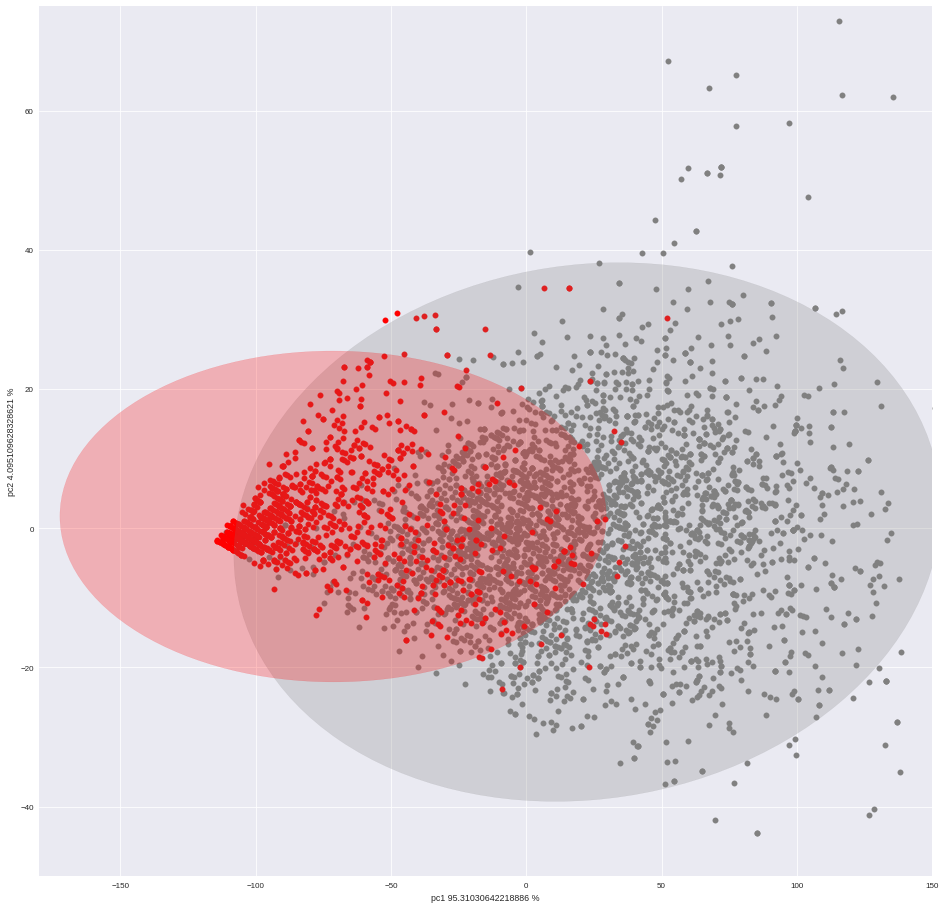

,Summary,Transformed White Winne
0,Mean,"[22.5400472872, -0.536387450207]"
1,Covariance matrix,"[[1901.07537348, 50.5506184042], [50.5506184042, 167.013239864]]"
2,EigenValues,"[1902.54775274, 165.540860604]"
3,EigenVectors,"[[-0.999576083602, 0.0291144824798], [-0.0291144824798, -0.999576083602]]"
4,Confidence,0.95
5,Chi-squared critical value,5.99146


,Summary,Transformed Red Winne
0,Mean,"[-71.4078633066, 1.69929908468]"
1,Covariance matrix,"[[1135.99106569, -0.454987253641], [-0.454987253641, 63.010475229]]"
2,EigenValues,"[1135.99125862, 63.010282296]"
3,EigenVectors,"[[-0.999999910095, -0.000424040411327], [0.000424040411327, -0.999999910095]]"
4,Confidence,0.95
5,Chi-squared critical value,5.99146


In [10]:
col_1,col_2='pc1','pc2'
alpha=0.05
freedomDegrees=2
plt.figure(figsize=(16,16))
plt.axis([-180,150,-50,75])

scatterPlot(plt,transformedWhiteWinneDF,col_1,col_2,'Gray')
summaryWhiteWinnePD = getProbabilityDensityContour(plt,transformedWhiteWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Gray',name='Transformed White Winne')

scatterPlot(plt,transformedRedWinneDF,col_1,col_2,'Red')
summaryRedWinnePD = getProbabilityDensityContour(plt,transformedRedWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Red',name='Transformed Red Winne')

plt.xlabel(col_1+' '+str(eigenvalues[0]*100)+' %')
plt.ylabel(col_2+' '+str(eigenvalues[1]*100)+' %')

plt.show()
display(summaryWhiteWinnePD)
display(summaryRedWinnePD)

## PCA con la muestra normalizada

### Normalizando datos

In [18]:
idCol = ['type']

features = [column for column in redWinneDF.columns if column not in idCol]

aggExpresions = [f.mean(c(colName)).alias('mean'+colName) for colName in features]+\
                [f.stddev(c(colName)).alias('stddev'+colName) for colName in features]


stdExpresions = [((c(colName)-c('mean'+colName))/c('stddev'+colName))\
                 .alias('std'+colName) for colName in features]

statisticsDF = trainingDF.select(aggExpresions)

stdTrainingDF = trainingDF.crossJoin(f.broadcast(statisticsDF))\
                              .select([c(idCol[0])]+stdExpresions)
    
stdTrainingDF.limit(5).toPandas()

,type,stdfixedAcidity,stdvolatileAcidity,stdcitricAcid,stdresidualSugar,stdchlorides,stdfreeSulfurDioxide,stdtotalSulfurdioxide,stddensity,stdpH,stdsulphates,stdalcohol,stdquality
0,0,-1.734762,-1.021185,1.697573,-0.830817,-0.846972,-0.389219,-0.029746,-1.353841,1.651094,-0.953022,0.264639,1.343810
1,0,-1.734762,1.307810,-1.261743,0.590859,-0.677007,0.235777,0.842710,-0.956633,1.965899,-0.138760,1.705992,2.488192
2,0,-1.656223,-0.040556,-0.698064,-0.809910,-0.818644,-0.730126,-0.492682,-1.784150,1.839977,-1.020877,1.705992,1.343810
3,0,-1.656223,-0.040556,-0.698064,-0.809910,-0.818644,-0.730126,-0.492682,-1.784150,1.839977,-1.020877,1.705992,1.343810
4,0,-1.656223,-0.040556,-0.698064,-0.809910,-0.818644,-0.730126,-0.492682,-1.784150,1.839977,-1.020877,1.705992,1.343810


Realizando la transformacion

In [19]:
stdSchema = [column for column in stdTrainingDF.columns if column not in idCol]
p = len(stdSchema)

meanVector = stdTrainingDF.describe().where(c('summary')==lit('mean'))\
                       .toPandas().as_matrix()[0][1:p+1]
        
labeledVectorsDF = stdTrainingDF.select(stdSchema+['type']).rdd\
                             .map(lambda x:(Vectors.dense(x[0:p]-Vectors.dense(meanVector)),x[p]))\
                             .toDF(['features','type'])

labeledVectorsDF.limit(5).toPandas()

,features,type
0,"[-1.97468290092, -1.02118504116, 1.69757300084, -0.83081705125, -0.846971956383, -0.389218932102...",0
1,"[-1.97468290092, 1.3078095477, -1.26174301674, 0.590858714117, -0.677007146378, 0.235777033644, ...",0
2,"[-1.89614388931, -0.0405557405853, -0.698063775293, -0.8099100547, -0.818644488049, -0.730125822...",0
3,"[-1.89614388931, -0.0405557405853, -0.698063775293, -0.8099100547, -0.818644488049, -0.730125822...",0
4,"[-1.89614388931, -0.0405557405853, -0.698063775293, -0.8099100547, -0.818644488049, -0.730125822...",0


### Obteniendo componentes de los datos normalizados

,explained variance
0,0.252457
1,0.222515
2,0.135722
3,0.089695


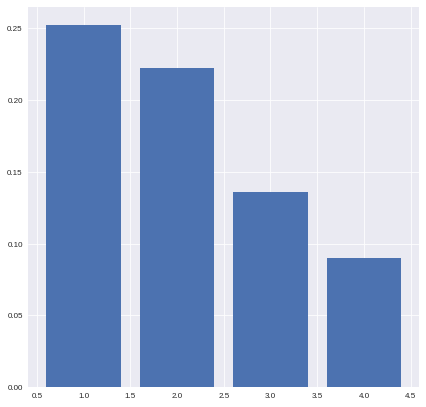

In [21]:
k=4
pcaModel = PCA(k=k, inputCol="features", outputCol="featuresPCA").fit(labeledVectorsDF)
transformedFeaturesDF = pcaModel.transform(labeledVectorsDF)

plt.figure(figsize=(7,7))
eigenvalues = [float(value) for value in pcaModel.explainedVariance]
plt.bar(list(range(1,len(eigenvalues)+1)),eigenvalues)
pd.DataFrame(eigenvalues,columns=['explained variance'])

Obteniendo un dataframe con los puntos mapeados

In [22]:
schema = ['pc'+str(k+1) for k in range(0,k)]

transformedWhiteWinneDF = transformedFeaturesDF.where(c('type') == lit(0))\
                                               .select(['featuresPCA']).rdd\
                                               .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                               .toDF(schema)

transformedRedWinneDF = transformedFeaturesDF.where(c('type') == lit(1))\
                                             .select(['featuresPCA']).rdd\
                                             .map(lambda r: [float(r[0].values[i]) for i in range (0,k)])\
                                             .toDF(schema)

projectedCanonicalsPD = pd.DataFrame([c for c in pcaModel.pc.toArray()],columns=schema)

### Biplot

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


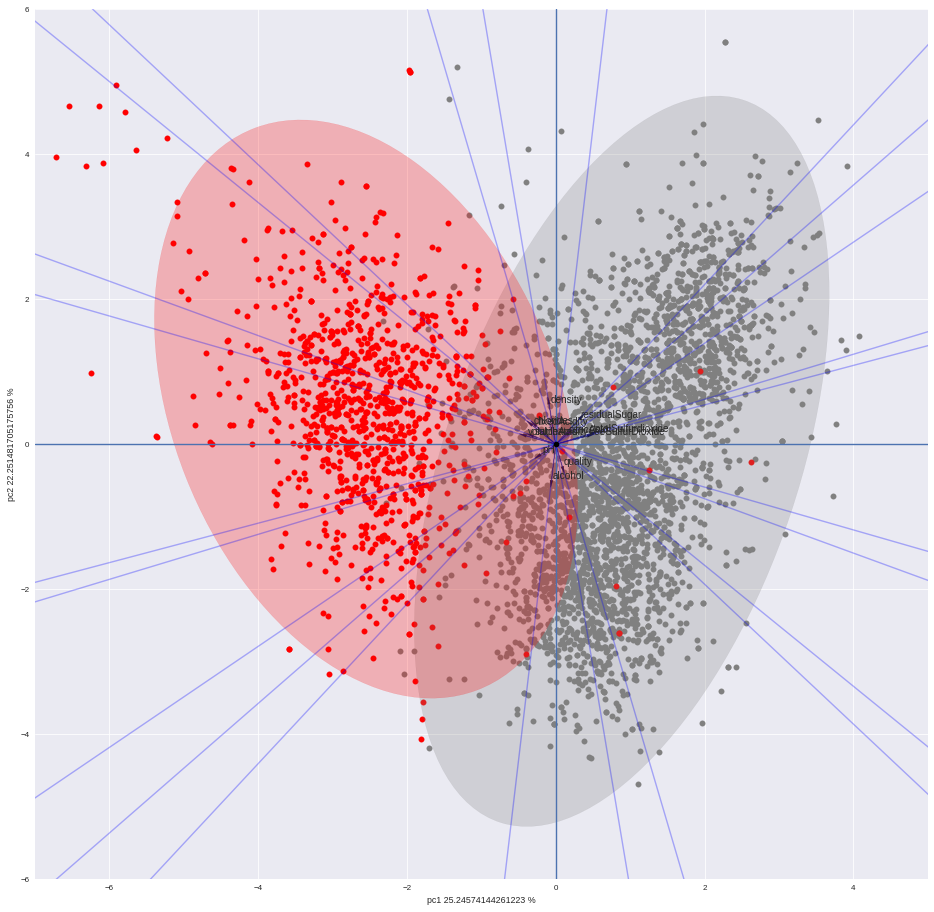

,Summary,Transformed White Winne
0,Mean,"[0.887516064024, -0.23334104858]"
1,Covariance matrix,"[[0.866278445996, 0.717277172469], [0.717277172469, 2.82962298827]]"
2,EigenValues,"[3.06374962734, 0.632151806925]"
3,EigenVectors,"[[0.310298404615, -0.950639206057], [0.950639206057, 0.310298404615]]"
4,Confidence,0.95
5,Chi-squared critical value,5.99146


,Summary,Transformed Red Winne
0,Mean,"[-2.54969647808, 0.486481732887]"
1,Covariance matrix,"[[0.901572863795, -0.391490544277], [-0.391490544277, 1.77299176953]]"
2,EigenValues,"[1.92303616734, 0.751528465991]"
3,EigenVectors,"[[-0.357879909174, -0.933767621311], [0.933767621311, -0.357879909174]]"
4,Confidence,0.95
5,Chi-squared critical value,5.99146


In [23]:
col_1,col_2='pc1','pc2'
alpha=0.05
freedomDegrees=2
plt.figure(figsize=(16,16))
plt.axis([-7,5,-6,6])

plotProjectedBase(plt,['pc1','pc2'],projectedCanonicalsPD,features)

scatterPlot(plt,transformedWhiteWinneDF,col_1,col_2,'Gray')
summaryWhiteWinnePD = getProbabilityDensityContour(plt,transformedWhiteWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Gray',name='Transformed White Winne')

scatterPlot(plt,transformedRedWinneDF,col_1,col_2,'Red')
summaryRedWinnePD = getProbabilityDensityContour(plt,transformedRedWinneDF,\
                            [col_1,col_2],alpha,freedomDegrees,\
                             color='Red',name='Transformed Red Winne')


plt.xlabel(col_1+' '+str(eigenvalues[0]*100)+' %')
plt.ylabel(col_2+' '+str(eigenvalues[1]*100)+' %')

plt.show()
display(summaryWhiteWinnePD)
display(summaryRedWinnePD)